## Парсер и анализатор чатов WhatsApp
### Данные предоставляются через экспорт чата в меню приложения.
Анализирует чат и показывает зависимости.   
Анализирует текст на наличие матерных слов и считает статистику использования мата.   
Датасет можно получить из приложения в меню чата:

1. Три точечки в верхнем-правом углу окна чата (группы)
![](images/1.png)

2. Раздел "Ещё"
![](images/2.png)

3. Выбрать "Экспорт чата"
![](images/3.png)

4. Экспортировать чат БЕЗ ФАЙЛОВ.
![](images/4.png)

Файл чата должен лежать в папке dataset.
Файл swears.txt - словарь матерных слов, можно добавить свои варианты.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
import markovify
import re
import glob
import string
import emoji
from collections import Counter
from IPython.display import display, HTML

### opening swears dictionary and log dataset
swears = open('dataset/swears.txt', 'r', encoding="utf-8")
swears = swears.read()
swears = swears.split('\n')

f = open(glob.glob('dataset/*WhatsApp*.txt')[0], 'r', encoding="utf-8")
f = f.read()
f = f.replace('\n', ' ')
stopwords = open('dataset/stopwords-ru.txt', 'r', encoding='utf-8').read().splitlines()

### initializing global variables
swears_dict = Counter()
words_dict = Counter()
plt.style.use('ggplot')


Задаём несколько функций, который помогут в дальнейшем.   
Счётчик слов   
Счётчик только матерных слов   
Сборщик библиотеки мата   
Сборщик общего словарного запаса   

In [2]:
def words_count(input_string):
	### function returns the number of words in input_string
	if (input_string[0] != '<' and input_string[-1] != '>'):
		return len(input_string.split())

def swear_count(input_string):
	### function returns the number of swear words found in input input_string
	input_string = input_string.lower()
	count = 0
	for word in swears:
		count += input_string.count(word)
	return count

def swears_collect(input_string):
	### function for adding swear words to global swear_dict dictionary from input input_string
	input_string = input_string.lower().split()
	for word in input_string:
		word = word.translate(str.maketrans('', '', string.punctuation + '«»'))
		for swear in swears:
			if swear in word:
				swears_dict[word] += 1

def to_dict(input_string):
	### fucntion for adding all words from input input_string to global words_dict dictionary
	input_string = input_string.lower()
	if (input_string[0] != '<' and input_string[-1] != '>'):
		input_string = input_string.split()
		for word in input_string:
			word = word.translate(str.maketrans('', '', string.punctuation + '«»' + '—' + '–'))
			if (word not in stopwords) and \
			(word not in string.punctuation) and \
			(word[0] not in emoji.UNICODE_EMOJI):
				words_dict[word] += 1

Прогоняем наш файл с чатом через парсер. Регулярным выражением выуживаем паттерны сообщений со структурой даты/автора/текста.
Пропускаем сервисные сообщения.
Печатем первые 5 строк датасета.

In [3]:
##### Parcing the raw dataset, cleaning it.
pattern = re.compile(r'(?P<timestamp>\d\d.\d\d.\d\d\d\d, \d\d:\d\d) - (?!\u200e)(?P<author>.*?): (?P<text>.*?)(?=( \d\d.\d\d.\d\d\d\d, \d\d:\d\d| $))')
match = re.findall(pattern, f)

df = pd.DataFrame.from_dict(match)
df = df.iloc[1:, 0:3]
df.columns=['timestamp', 'author', 'text']
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y, %H:%M')
df.set_index('timestamp', inplace=True)

display(df.head())

,author,text
timestamp,,
2018-12-31 14:06:00,Миша Колобегов,Давай
2018-12-31 14:06:00,Anton Petkov,Ох ебать
2018-12-31 14:06:00,Anton Petkov,Здарова
2018-12-31 14:06:00,Миша Колобегов,Антик
2018-12-31 14:06:00,Леха Харченко,Здарова


Добавляем вспомогательные колонки.   
swears_num - количество матерных слов в сообщении   
words_num - количество слов в сообщении   
media - тип сообщения (медиа или текст)   
hour - час в течении которого было оставлено сообщение

In [4]:
#### ADDING COLUMNS

### adding column with swears number in each message
df['swears_num'] = df['text'].map(swear_count)
# df.sort_values('swears_num', inplace=True)

### adding column with all words in message number
df['words_num'] = df['text'].map(words_count)

### adding column with boolean whether the message is just a meme or video
df['media'] = df['text'].map(lambda x: 'Media' if (x[0] == '<' and x[-1] == '>') else 'Text')

### adding 'hour' column for further grouping
df['hour'] = df.index.hour

Общее число сообщений:

In [5]:
### printing the number of messages
print('Общее число сообщений: {}'.format(df.shape[0]))

Общее число сообщений: 7538


Количество и список участников (тут везде "авторов") чата:

In [6]:
### building the list of authors, printing it
authors = df['author'].unique().tolist()
authors_num = len(authors)
print('В чате (группе) {} автора(ов): \n{}'.format(authors_num, authors))

В чате (группе) 8 автора(ов): 
['Миша Колобегов', 'Anton Petkov', 'Леха Харченко', 'Витек', 'Сева Баянович', 'Эдик Лыскунов', 'Стас Джулай', '+7 904 344-74-40']


Дата самого первого сообщения (создание чата), последнего сообщения, возраст чата:

In [7]:
### printing first message, last message, chat age
print('Дата первого сообщения: {}'.format(min(df.index)))
print('Дата последнего сообщения: {}'.format(max(df.index)))
days = int((max(df.index) - min(df.index)).days)
print('Возраст чата в днях: {}\nВозраст чата в годах: {:.2f}'.format(days, days / 365))
avg_msg_hour = df.groupby('hour').count()['text'] / days

Дата первого сообщения: 2018-12-31 14:06:00
Дата последнего сообщения: 2019-09-29 19:03:00
Возраст чата в днях: 272
Возраст чата в годах: 0.75


Составляем словари слов и матерных слов:

In [8]:
### buildig a dict (words_dict) with words from chat (text column). Not adding a column, but collecting data
df['text'].map(to_dict)

### building a dict of swears usage (swears_dict) from words_dict. Not adding a column, but collecting data
df['text'].map(swears_collect)

timestamp
2018-12-31 14:06:00    None
2018-12-31 14:06:00    None
2018-12-31 14:06:00    None
2018-12-31 14:06:00    None
2018-12-31 14:06:00    None
                       ... 
2019-09-29 18:50:00    None
2019-09-29 18:50:00    None
2019-09-29 18:50:00    None
2019-09-29 18:56:00    None
2019-09-29 19:03:00    None
Name: text, Length: 7538, dtype: object

Ещё один фрейм с количеством сообщений в неделю за весь период чата:

In [9]:
### calculating weekly messages number for alltime
msg_weekly = df.resample('W').count()['text']

Рассчитываем процент мата у каждого участника чата:
Первый фрейм со столбцами "Общее кол-во слов" - "Из них мата"
Второй топ по процентным соотношениям, самые матершинники вверху.

In [10]:
### calculating swear words usage for each author
words_swears_users = df.groupby('author').sum()[['words_num', 'swears_num']]
most_active = df.groupby('author').count()['text'].sort_values(ascending=False).index[0]
display(words_swears_users.head())
words_swears_users['percent'] = (words_swears_users['swears_num'] / words_swears_users['words_num']) * 100
words_swears_users = words_swears_users.sort_values(by='percent', ascending=False)
print('Самый активный автор: {}'.format(most_active))
print('\nСлова и матерные слова в процентах для каждого автора:')
print(words_swears_users['percent'].head())

,words_num,swears_num
author,,
+7 904 344-74-40,27.0,0
Anton Petkov,4467.0,133
Витек,8115.0,224
Леха Харченко,1049.0,34
Миша Колобегов,6216.0,45


Самый активный автор: Витек

Слова и матерные слова в процентах для каждого автора:
author
Леха Харченко    3.241182
Anton Petkov     2.977390
Витек            2.760320
Сева Баянович    1.831502
Эдик Лыскунов    0.776119
Name: percent, dtype: float64


Рассчёт матрицы корреляций Пирсона для каждого участника автора, с дальнейшей сортировкой наивысших коэффициентов наверх:
В данном случае коэффициент - по сути вероятность того, что участники общаются между собой, чем с другими участниками.

In [11]:
### calculating the pearsons correlation matrix for each pair of authors, fetching the best of them
corr_matrix = df.groupby(['hour', 'author']).count()['text']
print('\n')
corr_matrix = corr_matrix.unstack(level=-1, fill_value=0)
corr_matrix = corr_matrix.corr()
corr_matrix.replace(to_replace=1, value=0, inplace=True)
corr_matrix = corr_matrix.stack().sort_values(ascending=False).drop_duplicates()
print('Топ авторов в корреляциями во времени сообщений:')
display(corr_matrix.head())



Топ авторов в корреляциями во времени сообщений:


author          author        
Миша Колобегов  Витек             0.840906
Anton Petkov    Эдик Лыскунов     0.828766
Витек           Леха Харченко     0.807938
Леха Харченко   Миша Колобегов    0.772735
Сева Баянович   Леха Харченко     0.731589
dtype: float64

Время рисунков!
Первый график - общее количество сообщений у каждого участника.
При большом количестве участников (больше 10) - выводит только первые 10, предварительно отсортировав самых активных наверх. А то получится неразборчивая каша.

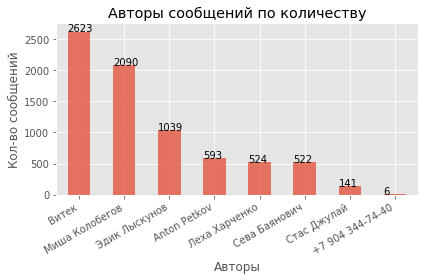

In [12]:
##### PLOTTING PART
### plots media/text percentage

### calculating and plotting overall authors messages number
authors_count = df.groupby(['author']).count()['text']
authors_count = authors_count.sort_values(ascending=False)
if authors_num > 10:
	title = 'Топ 10 авторов сообщений по количеству'
	authors_count = authors_count.iloc[:10]
else:
	title = 'Авторы сообщений по количеству'
ax = authors_count.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Кол-во сообщений')
ax.set_xlabel('Авторы')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

График (а еще и топ-5) публикации текстовых сообщений/медиа участниками. Видны предпочтения авторов, кто любит писать, а кто картинки слать.

media,Media,Text
author,,
Витек,630.0,1993.0
Миша Колобегов,503.0,1587.0
Эдик Лыскунов,169.0,870.0
Anton Petkov,93.0,500.0
Сева Баянович,133.0,389.0


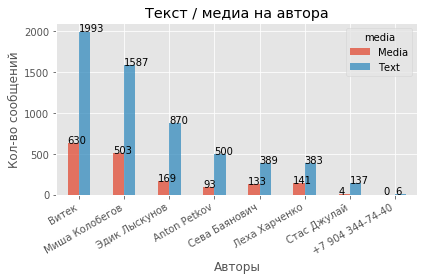

In [13]:
### calculating media/text ratio per author and plotting it
medias_per_capita = df.groupby(['author', 'media']).count()['text']
medias_per_capita = medias_per_capita.unstack(level=1)
medias_per_capita = medias_per_capita.sort_values(by='Text', ascending=False)
if authors_num > 10:
	medias_per_capita = medias_per_capita.iloc[:10, :]
	title = 'Топ 10 медиа / текст на автора'
else:
	title = 'Текст / медиа на автора'

display(medias_per_capita.head())

ax = medias_per_capita.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Кол-во сообщений')
ax.set_xlabel('Авторы')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

График общей активности чата за всю историю:
новая года сразу видна)))

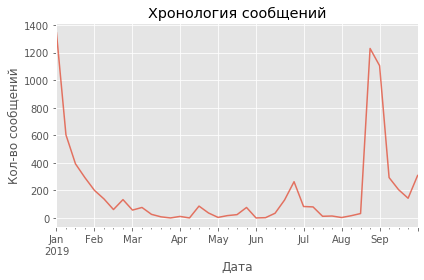

In [14]:
### plotting overall messages history
msg_weekly.plot(kind='line', title='Хронология сообщений', alpha=0.75)
plt.xlabel('Дата')
plt.ylabel('Кол-во сообщений')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

График использования картинок/мемасов/котят/еды вместо текста:

media
Media    1673
Text     5865
Name: text, dtype: int64


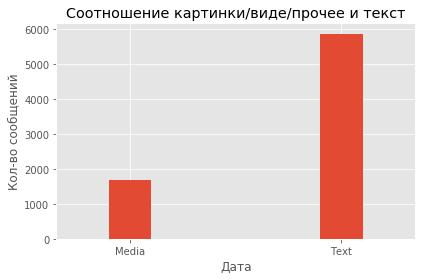

In [15]:
medias = df.groupby(['media']).count()['text']
print(medias)
medias.plot(kind='bar', title='Соотношение картинки/виде/прочее и текст', width=0.20)
plt.xlabel('Дата')
plt.ylabel('Кол-во сообщений')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

График среднего количества сообщений в определённый час суток:
Задавать свои вопросы с вероятностью быстро получить ответ лучше именно в пиковые его значения.

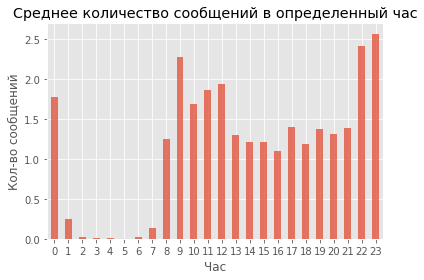

In [16]:
avg_msg_hour.plot(kind='bar', title='Среднее количество сообщений в определенный час', alpha=0.75, )
plt.xlabel('Час')
plt.ylabel('Кол-во сообщений')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Топ 20 слов используемых в чате: Ограничил размер от 3 символов, ибо предлоги всегда в топе использования в человеческой речи.
И топ 20 матерных слов в чате:
В списке (слово, его количество)

In [17]:
print('Топ 20 слов используемых в чате, длинее 3 букв:')
display(pd.DataFrame(words_dict.most_common(20)))
print('\n')
print('Топ 20 матерных слов: \n')
display(pd.DataFrame(swears_dict.most_common(20)))
print('\n')
print('Общий процент мата в чате:')
print(round((df['swears_num'].sum() / df['words_num'].sum()) * 100, 4))

Топ 20 слов используемых в чате, длинее 3 букв:


,0,1
0,брат,207
1,че,148
2,бля,78
3,ебать,75
4,новая,70
5,пиздец,66
6,братан,65
7,блять,58
8,хз,50
9,помню,48




Топ 20 матерных слов: 



,0,1
0,ебать,75
1,пиздец,66
2,нахуй,32
3,хуй,30
4,пизда,24
5,ахуеть,16
6,хуйня,13
7,ахуел,11
8,похуй,11
9,хуйню,7




Общий процент мата в чате:
1.8766


### Пробуем сгенерировать 20 сообщений моделью на цепях маркова обученной на сообщениях самого активного автора.

In [18]:
### procesing some markov chains generated messages
### trying to generate 20 messages
def shit_detector(string):
    if (string[0] == '<' and string[-1] == '>') or \
        'http' in string:
        return False
    else:
        return True
corpus = df[(df['author'] == most_active) & (df['text'].apply(shit_detector))]['text']

corpus = '\n'.join(corpus.tolist())

text_model = markovify.NewlineText(corpus, well_formed=False)

number_of_lines = 20
count = 0

print('Авторство: ', most_active, '\n')

while True:	### Skiping None values
	output = text_model.make_sentence()
	if output != None:
		print(output)
		if count == number_of_lines:
			break
		else:
			count += 1

Авторство:  Витек 

К матушке на работу ипаную
В смысле че за Масон! Уже настораживает
Справки о доходах в собес принесли, у нас на риижте сегодня камаз прям на кольце сгорел к чертям
Мишаня, а у тебя утро😅😅🤣
Мне в любое время😅
Ебать уже люди за покупками приебошили в лерую в 7 утра уже очередь
Я в нее лет 13 назад в него играл крайний раз
Антоха, че за тигр?😅👍💪
Там просто спор что были ли когда нибудь боинги 747?
Эдик, а ты в эти выходные уезжаешь?
Лекс есть во всех клубах есть 1.6
Вы вопросы задаете, я как псина вспотел. Малого накатал
Да она уже не играю
Ага, хер там че надо было?
А начал я в ахуе😅😅😅
То у него ранг блжество и там химией чистили
Ну синька это как ЭКО
Ну там я думаю можно
Мишаня, а че на ленина щас
Так а че с собакой???🤣🤣🤣
Севка, ты ж только сказал, что сосок много
